Load a time series of MODIS (MxD11_L2) LST observations from a directory

In [1]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt

%matplotlib inline

Find all HDF files in a specified directory

In [2]:
def getListOfFiles(dirName,ext):
    '''Create a list of file names in the given directory with specified file extension.'''
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Only match files with the correct extension
        if '.'+ext == os.path.splitext(entry)[1]:
            # Create full path and add to list
            fullPath = os.path.join(dirName, entry)
            allFiles.append(fullPath)       
    return allFiles

In [3]:
searchDir = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MODIS\Tuolumne_2017_MxD11_L2'
file_list = getListOfFiles(searchDir,'hdf')

Open all the datasets

In [4]:
datasets = [xr.open_dataset(path, chunks={}) for path in file_list]

Inspect the datasets

In [5]:
datasets

[<xarray.Dataset>
 Dimensions:     (Along_swath_lines_1km:MOD_Swath_LST: 2030, Coarse_swath_lines_5km:MOD_Swath_LST: 406, Coarse_swath_pixels_5km:MOD_Swath_LST: 271, Cross_swath_pixels_1km:MOD_Swath_LST: 1354)
 Dimensions without coordinates: Along_swath_lines_1km:MOD_Swath_LST, Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST
 Data variables:
     Latitude    (Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST) float32 dask.array<shape=(406, 271), chunksize=(406, 271)>
     Longitude   (Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST) float32 dask.array<shape=(406, 271), chunksize=(406, 271)>
     LST         (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) float32 dask.array<shape=(2030, 1354), chunksize=(2030, 1354)>
     QC          (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) uint16 dask.array<shape=(2030, 1

Define a function to interpolate from the coarse resolution latitude and longitude to the same resolution as the LST SDS

In [9]:
def interpLatLon(ds):
    '''Given a MODIS (MxD11_L2) xarray.Dataset (ds), interpolate between arrays of Latitude and Longitude values.
       Return a dataset with Lat/Lon arrays of the correct size to match the LST SDS.'''
    
    x = ds['Coarse_swath_pixels_5km:MOD_Swath_LST'].values # swath pixels, along-track (x values)
    y = ds['Coarse_swath_lines_5km:MOD_Swath_LST'].values # swath lines, cross-track (y values)
    #print(x.shape,y.shape)
    xx, yy = np.meshgrid(x, y) # Create meshgrid of pixel/line values
    # Create pixel/line coordinates for between the coarse pixels (1/scale_factor)
    scale_factor = 5
    step = 1 / scale_factor
    offset = 2
    xnew = np.arange(0-(offset*step), ds['Coarse_swath_pixels_5km:MOD_Swath_LST'].shape[0]-(offset*step), step)
    ynew = np.arange(0-(offset*step), ds['Coarse_swath_lines_5km:MOD_Swath_LST'].shape[0]-(offset*step), step)
    
    # Interpolate within the Latitude array
    z_lat = ds.Latitude.values
    fn_lat = interpolate.interp2d(x, y, z_lat, kind='linear')
    znew_lat = fn_lat(xnew, ynew)
    if znew_lat.shape[1] > ds.LST.shape[1]: # if our interpolated Latitude array is longer than the LST SDS
        znew_lat = znew_lat[:,0:ds.LST.shape[1]] # make it them same shape
    # Add new Latitudes to MODIS dataset
    lat = xr.DataArray(znew_lat, dims=['Along_swath_lines_1km:MOD_Swath_LST', 'Cross_swath_pixels_1km:MOD_Swath_LST'])
    ds['Latitude_1km'] = lat
    
    # Interpolate within the Longitude array
    z_lon = ds.Longitude.values
    fn_lon = interpolate.interp2d(x, y, z_lon, kind='linear')
    znew_lon = fn_lon(xnew, ynew)
    if znew_lon.shape[1] > ds.LST.shape[1]: # if our interpolated Longitude array is longer than the LST SDS
        znew_lon = znew_lon[:,0:ds.LST.shape[1]] # make it them same shape
    # Add new Longitudes to MODIS dataset
    lon = xr.DataArray(znew_lon, dims=['Along_swath_lines_1km:MOD_Swath_LST', 'Cross_swath_pixels_1km:MOD_Swath_LST'])
    ds['Longitude_1km'] = lon
    
    # Set coordinates to the newly interpolated Lat and Lon values
    #ds.reset_coords(drop=True)
    ds = ds.set_coords(['Longitude_1km', 'Latitude_1km'])
    
    return ds

Create a new dataset with this function, with the newly interpolated Latitude and Longitude values

In [10]:
datasets_new = [interpLatLon(dataset) for dataset in datasets]

In [11]:
datasets[0]['Along_swath_lines_1km:MOD_Swath_LST'].values

array([   0,    1,    2, ..., 2027, 2028, 2029], dtype=int64)

Find the LST value for a pixel at a specific location specified by a latitude and longitude

And make some plots around our area of interest

In [94]:
lat_obs = 37.88 #approx locaiton of Gaylor Pit
long_obs=-119.31
temp=[]
datetime=[]
viewtime=[]
viewangle=[]
temp_mean=[]
temp_min=[]
temp_max=[]
b=0.5 #bounds, +/- in degrees lat/lon
n=0
for f in datasets_new:
    # Find LST value at the specified coordinates
    coordinates = np.unravel_index((np.abs(f.Latitude_1km - lat_obs) + np.abs(f.Longitude_1km - long_obs)).argmin(), f.Latitude_1km.shape)
    temp.append(f.LST[coordinates].values - 273.15)
    # Make a separate array of pixels around our point of interest
    m = 1 # for a 3x3 grid, m=1
    temp_grid = f.LST[coordinates[0]-m:coordinates[0]+1+m,coordinates[1]-m:coordinates[1]+1+m].values
    temp_mean.append(np.nanmean(temp_grid) - 273.15)
    temp_min.append(np.nanmin(temp_grid) - 273.15)
    temp_max.append(np.nanmax(temp_grid) - 273.15)
    
    # Find the date and time of this observation
    i = f.attrs['CoreMetadata.0'].find('RANGEBEGINNINGDATE')
    date = f.attrs['CoreMetadata.0'][i+80:i+90]
    i = f.attrs['CoreMetadata.0'].find('RANGEBEGINNINGTIME')
    time = f.attrs['CoreMetadata.0'][i+80:i+95]
    datetime.append(pd.to_datetime('{} {}'.format(date,time)))
    
    # Record view time and view angle of this point
    viewtime.append(f.View_time[coordinates].values)
    viewangle.append(f.View_angle[coordinates].values)
    
    # print and save figure
    #fig, ax = plt.subplots(figsize=(7,7))
    #ax = plt.axes(projection=ccrs.Orthographic(-117, 39))
    #f.LST.plot.pcolormesh('Longitude_1km', 'Latitude_1km',cmap='magma',
    #                      vmin=250, vmax=350, ax=ax, transform=ccrs.PlateCarree(),zorder=30);
    ##ax.set_global(); #ax.stock_img();
    #ax.coastlines();
    #ax.gridlines();
    #ax.set_extent([long_obs-b,long_obs+b, lat_obs-b,lat_obs+b], crs=ccrs.PlateCarree())
    #ax.set_title('MODIS LST {}'.format(datetime[n]))
    #plt.savefig('figures/MODIS LST {}.png'.format(n))
    #plt.close('all')
    n+=1

d = {'datetime': datetime, 
     'temperature': temp, 
     'viewtime': viewtime, 
     'viewangle': viewangle,
     'temp_min': temp_min,
     'temp_max': temp_max,
     'temp_mean': temp_mean
     }
modis = pd.DataFrame(data=d)
modis['datetime'] +=  pd.to_timedelta(-7, unit='h')
modis = modis.sort_values('datetime').reset_index()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered


In [95]:
modis

,index,datetime,temperature,viewtime,viewangle,temp_min,temp_max,temp_mean
0,0,2017-04-19 23:05:00,-5.489996,22.2,10.0,-6.329993,-4.530005,-5.590002
1,8,2017-04-20 03:20:00,-6.290015,2.4,38.5,-6.510016,-5.470007,-6.097998
2,1,2017-04-20 11:05:00,4.369989,10.2,60.5,1.929987,4.369989,2.990015
3,2,2017-04-20 12:45:00,1.990015,11.8,64.5,-0.570013,3.529993,1.558862
4,9,2017-04-20 14:25:00,NaN,nan,nan,3.369989,4.529993,3.969995
5,3,2017-04-20 22:10:00,-4.410010,21.2,62.5,-7.230017,-4.410010,-5.700018
6,4,2017-04-20 23:50:00,-4.590002,22.9,62.5,-5.870001,-4.470007,-5.130011
7,10,2017-04-21 02:25:00,-4.190009,1.5,49.5,-5.570013,-4.190009,-4.616675
8,5,2017-04-21 11:50:00,7.230005,10.9,4.0,5.829980,7.230005,6.449976
9,11,2017-04-21 13:30:00,NaN,nan,nan,4.290002,6.890009,5.663324


Load Gaylor Pit snow surface temperature data

In [96]:
# Gaylor Pit surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\GaylorPit\GaylorPit2017_039_T15min.csv'
gaylor = pd.read_csv(filepath)

# Make some data type and unit conversions
gaylor['datetime'] = pd.to_datetime(gaylor['TIMESTAMP']) # timestamp string to pandas datetime
gaylor['Judd_Air_TempC'] = (gaylor['Judd_Air_TempF'] - 32) / 1.8 # temperature F to temperature C
gaylor['Judd_Depth_cm'] = gaylor['Judd_Depth_in'] * 2.54 # snowdepth inches to snowdepth cm


Plot MODIS LST and Gaylor Pit temperature data together

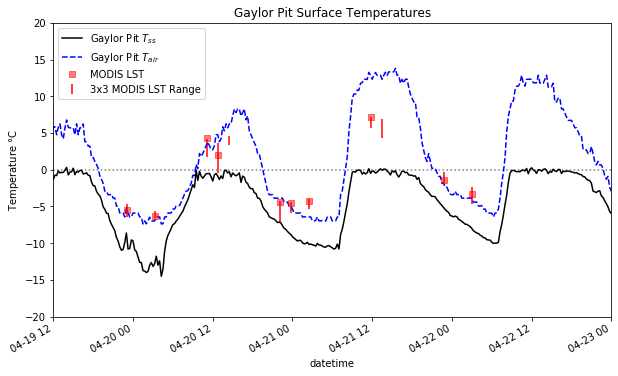

In [97]:
starttime = pd.to_datetime('2017-04-19 12:00')
endtime = pd.to_datetime('2017-04-23')

fig, ax = plt.subplots(figsize=(10,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')
modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
plt.errorbar(modis.datetime,modis.temp_mean,
             yerr=np.array((modis.temp_max-modis.temp_min)/2),
             linestyle='None',c='r',linewidth=1.5,
             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))

plt.legend()
ax.set_xlim((starttime,endtime))
ax.set_ylim((-20,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Gaylor Pit Surface Temperatures');

Find the Gaylor Pit observations closest in time to our MODIS data, compute the difference between MODIS LST and Gaylor Pit Tsnow and Tair

In [98]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

In [112]:
# Compute the difference in temperatures (Gaylor Pit - MODIS)
delta_tair = []
delta_tsnow = []
gaylor_tair = []
gaylor_tsnow = []

i = 0
for time in modis['datetime']:
    gaylor_time = (nearest(gaylor['datetime'],time))
    #print('MODIS Time:{} \t Gaylor Time:{}'.format(time,gaylor_time))
    gaylor_tsnow.append(gaylor['TT_C'][gaylor['datetime']==gaylor_time].values[0])
    gaylor_tair.append(gaylor['Judd_Air_TempC'][gaylor['datetime']==gaylor_time].values[0])
    modis_t = modis.temperature[modis['datetime']==time].values[0]
    modis_tmin = modis.temp_min[modis['datetime']==time].values[0]
    modis_tmax = modis.temp_max[modis['datetime']==time].values[0]
    #print('{} \t {} \t {}'.format(modis_t,gaylor_tsnow,gaylor_tair))
    delta_tsnow.append(modis_t - gaylor_tsnow[i])
    delta_tair.append(modis_t - gaylor_tair[i])
    i+=1


How does the difference between MODIS LST and ground data change as a function of view angle?

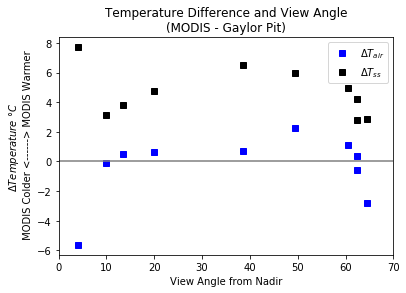

In [114]:
plt.plot(modis.viewangle,delta_tair,'sb',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis['viewangle'],delta_tsnow,'sk',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('View Angle from Nadir')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.xlim([0,70])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Temperature Difference and View Angle\n(MODIS - Gaylor Pit)');

# These MODIS LST values are often warmer than both Gaylor Pit Tair and Ts

If we assume a weighted mean between tforest (guessing that it can be represented here by tair) and tsnow, figure out what those weights are here.

In other words:

MODIS LST = ( (1-n) * Tforest + n * Tsnow )

where 1-n is the forest fraction of the pixel, and n is the snow fraction of the pixel

Therefore solving for n:

n = (MODIS LST - Tforest) / (Tsnow - Tforest)

In [115]:
snow_fraction = []
for i in range(0,len(modis.temperature)):
    snow_fraction.append(( modis.temperature[i] - gaylor_tair[i] ) / (gaylor_tsnow[i] - gaylor_tair[i]))


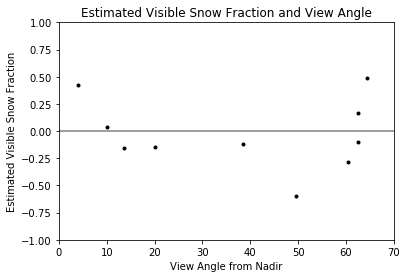

In [116]:
plt.plot(modis['viewangle'],snow_fraction,'.k');
plt.xlabel('View Angle from Nadir')
plt.ylabel('Estimated Visible Snow Fraction')
plt.xlim([0,70])
plt.ylim([-1,1])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Estimated Visible Snow Fraction and View Angle');

# Where snow fraction is < 0, MODIS LST is higher than Tair